# Current

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import numpy as np
import pandas as pd
import h5py
import tensorflow as tf
import itertools
import seaborn as sns

from string import ascii_letters

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import RobustScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

%matplotlib inline

In [32]:
folder_path = "/content/drive/MyDrive/Paper/Dataset"

In [33]:
pd_tr = pd.read_csv(folder_path + '/cur_training_all.csv')
pd_v = pd.read_csv(folder_path + '/cur_validation_all.csv')

In [34]:
print(len(pd_tr))
print(len(pd_v))
print(pd_tr.shape)
print(pd_v.shape)

305534
38210
(305534, 48)
(38210, 48)


In [35]:
pd_tr_labels = pd_tr.iloc[:, -1]
pd_v_labels = pd_v.iloc[:, -1]

In [36]:
pd_tr = pd_tr.drop(columns = ['Date','WATT','LABEL'])
pd_v = pd_v.drop(columns = ['Date','WATT','LABEL'])

In [37]:
drop_corr_pd_tr = pd_tr.drop(["R_Skewness", "S_Skewness", "T_Skewness", "R_Kurtosis", "R_Impulse", "ST_phase", "TR_phase","T_Kurtosis", "RS_Level"],axis=1)
drop_corr_pd_v = pd_v.drop(["R_Skewness", "S_Skewness", "T_Skewness", "R_Kurtosis", "R_Impulse", "ST_phase", "TR_phase","T_Kurtosis", "RS_Level"],axis=1)

In [46]:
def draw_seaborn_corr(corr_data):
  sns.set_theme(style="white")

  # Generate a large random dataset
  rs = np.random.RandomState(33)
  mask = np.triu(np.ones_like(corr_data, dtype=bool))

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr_data, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [47]:
%matplotlib inline

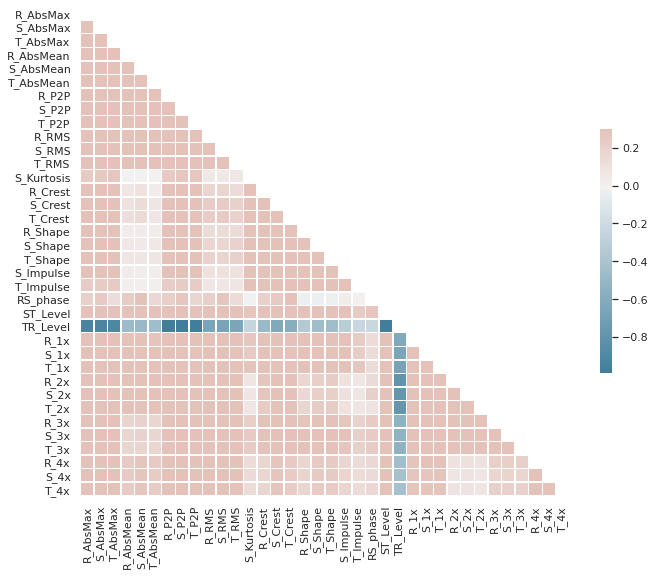

In [51]:
corr = drop_corr_pd_tr.corr()
draw_seaborn_corr(corr)

### 1.1 split data set 

In [52]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(pd_tr, pd_tr_labels, test_size=0.2, random_state=42)

### 1.2. Validation

In [53]:
print(x_train.shape)
print(y_train.shape)
print("="*50)
print(x_test.shape)
print(y_test.shape)
print("="*50)
x_valid = pd_v
y_valid = pd_v_labels

print(x_valid.shape)
print(y_valid.shape)

(244427, 45)
(244427,)
(61107, 45)
(61107,)
(38210, 45)
(38210,)


### 1.3 normalize

주제가 피쳐에 대한 강건함이므로, 스케일러에 대한 고민도 해야할 것이다.

본 데이터는 Multivariate이며, 1개의 Channel만 갖는다. 우리는 multivariate variable with one channel 형태로 바꿔주고자 하며, 이는 아래와 같다.

In [54]:
# CNN, RNN 모델의 입력 변수는 채널 축 1개 차원을 확장시킨 3D Tensor이다.
# 즉 아래 CNN, RNN 모델은 x_train, x_valid, x_test를 입력 변수로 넣지 않고, 
# x_train_exp, x_valid_exp, x_test_exp을 넣는다. 
x_train_exp = np.expand_dims(x_train, -1)  # 채널 축 1개 차원을 확장 시킨(Expand) X_train
x_valid_exp = np.expand_dims(x_valid, -1)  # 채널 축 1개 차원을 확장 시킨(Expand) X_vaild 
x_test_exp = np.expand_dims(x_test, -1)  # 채널 축 1개 차원을 확장 시킨(Expand) X_test

# 위와 동일한 코드
# x_train_exp = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# x_valid_exp = x_train.reshape((x_valid.shape[0], x_valid.shape[1], 1))
# x_test_exp = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print("x_train_exp의 형태:", x_train_exp.shape)
print("y_train_exp의 형태:", y_train.shape)

print("=" * 50)

print("x_valid_exp의 형태:", x_valid_exp.shape)
print("y_valid_exp의 형태:", y_valid.shape)

print("=" * 50)

print("x_test_exp의 형태:", x_test_exp.shape)
print("y_test_exp의 형태:", y_test.shape)

x_train_exp의 형태: (244427, 45, 1)
y_train_exp의 형태: (244427,)
x_valid_exp의 형태: (38210, 45, 1)
y_valid_exp의 형태: (38210,)
x_test_exp의 형태: (61107, 45, 1)
y_test_exp의 형태: (61107,)


In [55]:
num_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))
num_classes

5

# 3. LSTM

In [56]:
def make_lstm_model():
  model=Sequential()
  model.add(LSTM(units=256, return_sequences=True))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model. add(Dense(5, activation='softmax'))
  return model

In [57]:
lstm = make_lstm_model()

In [58]:
EPOCHS = 300
BATCH_SIZE = 64

In [59]:
lstm.compile(loss="sparse_categorical_crossentropy", 
                  optimizer='adam', 
                  metrics=["accuracy"]
                 )

In [60]:
callbacks = [ModelCheckpoint(folder_path + '/best_model.h5',
                             monitor='val_loss',
                             save_best_only=True),
             ReduceLROnPlateau(
                 monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
                 ),
             EarlyStopping(monitor="val_loss", patience=10, verbose=1)
             ]

In [61]:
history = lstm.fit(
    x_train_exp,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=(x_valid_exp, y_valid),
    verbose=1
)

Epoch 1/300
3820/3820 [==============================] - 22s 5ms/step - loss: 0.2631 - accuracy: 0.9030 - val_loss: 0.2940 - val_accuracy: 0.8925
Epoch 2/300
3820/3820 [==============================] - 20s 5ms/step - loss: 0.1204 - accuracy: 0.9547 - val_loss: 0.2575 - val_accuracy: 0.8976
Epoch 3/300
3820/3820 [==============================] - 21s 5ms/step - loss: 0.0993 - accuracy: 0.9630 - val_loss: 0.2511 - val_accuracy: 0.9229
Epoch 4/300
3820/3820 [==============================] - 20s 5ms/step - loss: 0.0851 - accuracy: 0.9684 - val_loss: 0.2267 - val_accuracy: 0.9317
Epoch 5/300
3820/3820 [==============================] - 21s 5ms/step - loss: 0.0766 - accuracy: 0.9719 - val_loss: 0.3409 - val_accuracy: 0.8867
Epoch 6/300
3820/3820 [==============================] - 20s 5ms/step - loss: 0.0715 - accuracy: 0.9735 - val_loss: 0.4261 - val_accuracy: 0.8971
Epoch 7/300
3820/3820 [==============================] - 20s 5ms/step - loss: 0.0662 - accuracy: 0.9759 - val_loss: 0.4951 -

In [62]:
scores = lstm.evaluate(x_test_exp, y_test)

print("\n""Test accuracy", scores[1])
print("\n""Test loss", scores[0])
print("%s: %.2f%%" % (lstm.metrics_names[1], scores[1]*100))

1910/1910 [==============================] - 5s 3ms/step - loss: 0.0277 - accuracy: 0.9897

Test accuracy 0.9897229671478271

Test loss 0.027718115597963333
accuracy: 98.97%


In [255]:
def draw_confusion_matrix(model, xt, yt, model_name):
    Y_pred = model.predict(xt)
    if model_name in ["cnn", "lstm"]:
        y_pred = np.argmax(Y_pred, axis=1)
    else: y_pred = Y_pred
    plt.figure(figsize=(5,5))
    cm = confusion_matrix(yt, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['False', 'True'], rotation=45)
    plt.yticks(tick_marks, ['False', 'True'])
    thresh = cm.max()/1.2
    normalize = False
    fmt = '.2f' if normalize else 'd'
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, format(cm[i,j], fmt), 
                 horizontalalignment="center", 
                 color="white" if cm[i,j] > thresh else "black", 
                 fontsize=12)
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig(folder_path + '/{}_cm.png'.format(model_name), dpi=100, bbox_inches='tight')  # 그림 저장
    plt.show()
    print(classification_report(yt, y_pred))

In [256]:
from sklearn.metrics import roc_curve, auc

def draw_roc(model,xt, yt, model_name):
    Y_pred = model.predict(xt)
    if model_name in ["cnn", "lstm"]:
        y_pred = np.argmax(Y_pred, axis=1)
    else: y_pred = Y_pred
    fpr, tpr, thr = roc_curve(yt, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {};'.format(model_name))
    plt.legend(loc="lower right")
    plt.ion()
    plt.tight_layout()
    plt.savefig(folder_path + '/{}_roc.png'.format(model_name), dpi=100, bbox_inches='tight')  # 그림 저장
    plt.show()

In [257]:
def plot_loss_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history["val_loss"])
    plt.title("Training & Validation Loss")
    plt.ylabel("loss", fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "validation"], loc="best")
    plt.tight_layout()
    plt.savefig(folder_path + '/{}.png'.format(pic_name), dpi=100, bbox_inches='tight')  # 그림 저장
    plt.show()
    plt.close()

In [258]:
def plot_prediction_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history["sparse_categorical_accuracy"])
    plt.plot(history.history["val_" + "sparse_categorical_accuracy"])
    plt.title("model " + "Prediction Accuracy")
    plt.ylabel("sparse_categorical_accuracy", fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "validation"], loc="best")
    plt.tight_layout()
    plt.savefig(folder_path + '/{}.png'.format(pic_name), dpi=100, bbox_inches='tight')  # 그림 저장
    plt.show()
    plt.close()

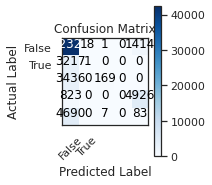

              precision    recall  f1-score   support

           0       0.78      0.97      0.86     43755
           1       0.05      0.00      0.00      3218
           2       0.95      0.05      0.09      3605
           3       0.00      0.00      0.00      5749
           4       0.01      0.02      0.01      4780

    accuracy                           0.70     61107
   macro avg       0.36      0.21      0.19     61107
weighted avg       0.62      0.70      0.62     61107



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [263]:
draw_confusion_matrix(cnn, x_test_exp, y_test, "cnn")

In [260]:
draw_roc(lstm, x_test_exp, y_test, "lstm")

NameError: ignored

In [261]:
plot_loss_graph(lstm, "lstm")

NameError: ignored

In [ ]:
plot_prediction_graph(lstm, "lstm")